In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from matplotlib.pyplot import imshow

### Load Data

In [2]:
numcat = 6 #number of categories
categories = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

In [3]:
# directory = r'./Medical_MNIST/'
# train, test = [], []
# for i in range(numcat):
#     imagearray = []
#     for image_raw in os.listdir(directory + categories[i]):
#         image_np = (np.array(Image.open(os.path.join(directory + categories[i], image_raw))).flatten())
#         image = np.append(image_np, i)
#         imagearray.append(image.astype('uint8'))
#     train += imagearray[0:int(0.8*len(imagearray))]
#     test += imagearray[int(0.8*len(imagearray)):]
# # data = np.array(imagearray)
# train = np.array(train)
# test = np.array(test)


In [4]:
# #saving data for faster loading in future
# np.save('Medical_train.npy', train)
# np.save('Medical_test.npy', test)

In [5]:
train = np.load('Medical_train.npy')
test = np.load('Medical_test.npy')
X_train, y_train = train[:, :-1], test[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [6]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(47163, 4096) (11791,) (11791, 4096) (11791,)


In [7]:
# def cross_valid_split(dataset, folds):
#         dataset_split = []
# #         df_copy = dataset
#         fold_size = int(dataset.shape[0] // folds)
        
#         # for loop to save each fold
#         for i in range(folds):
#             fold = []
#             # while loop to add elements to the folds
#             while len(fold) < fold_size:
#                 # select a random element
#                 r = randrange(df_copy.shape[0])
#                 # determine the index of this element 
#                 index = df_copy.index[r]
#                 # save the randomly selected line 
#                 fold.append(df_copy.loc[index].values.tolist())
#                 # delete the randomly selected line from
#                 # dataframe not to select again
#                 df_copy = df_copy.drop(index)
#             # save the fold     
#             dataset_split.append(np.asarray(fold))
            
#         return dataset_split

In [8]:
# directory = r'./Medical_MNIST/'
# image_np = np.array(Image.open(os.path.join(directory + 'AbdomenCT', '000000.jpeg')))
# imshow(image_np/255, cmap = 'gray')
# # img.show()

### Data Visualization(PCA/tSNE)

### Some data analysis

In [9]:
# df_h.plot.scatter(x = 'restbps', y = 'chol')
# df_h.plot.scatter(x = 'restbps', y = 'age')
# df_h.plot.scatter(x = 'age', y = 'chol')

# Naive Bayes Classifier - with Gaussian or some other density functions as density estimates of individual features for a particular class

### MLE

In [10]:
def get_naive_params(X):
    for i in range(numcat):
        
    mu = np.mean(X, axis = 0)
    var = np.var(X, axis = 0)
    return {'mu':mu, 'var':var}

def performance_metrics(y_pred_test, y_test):
    '''gives the TPR, FPR, acc, precision, recall and F1 score by comparing the 2 input arrays'''
    #for precision, recall, class 1 will be positive class (ie the person ahs a health condition) 
    #and 0 as negative class (no health condition)
    TP = np.logical_and(y_pred_test==y_test,y_pred_test == 1).sum()
    FP = np.logical_and(y_pred_test!=y_test,y_pred_test == 1).sum()
    TN = np.logical_and(y_pred_test==y_test,y_pred_test == 0).sum()
    FN = np.logical_and(y_pred_test!=y_test,y_pred_test == 0).sum()
    ACC = (TP+TN)/(TP+TN+FP+FN)
    P = (TP)/(TP+FP)
    R = (TP)/(TP+FN)
    F1 = 2*P*R/(P+R)
    TPR = R
    FPR = FP/(FP+TN)
    
    return {'accuracy':ACC, 'precision':P, 'recall':R, 'F1':F1, 'TPR':TPR, 'FPR': FPR}

def getpriors(y_train):
#     priors = [X_train_0.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0]), X_train_1.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0])]
    priors = [(y_train==i).sum()/y_train.shape[0] for i in range(6)]
        
    return priors

def gaussian_univariate(x, mu, var):
    """ to get the value of pdf having scalar params mu and var, @x """
    diff = (x - mu)
    pdf_x = (1/(np.sqrt(2*np.pi)))* (1/np.sqrt(var)) * (np.exp(-0.5*(diff**2)/(var)))
    return pdf_x.item()

def naive_likelihood(x, mu_array, var_array):
    '''mu_array, and var_array are d dimensional array where d is the size of x which is the number of features'''
    likelihood = 1
    for i in range(x.shape[0]):
        likelihood = likelihood * gaussian_univariate(x[i], mu_array[i], var_array[i])
    
    return likelihood
        
def predict_naive(X_test, threshold, priors, naive_params0, naive_params1):
    y_pred_test = np.zeros((X_test.shape[0], 1))
#     print(thresh)
    for i in range(X_test.shape[0]):
        likelihood_0 = naive_likelihood(X_test[i], naive_params0['mu'], naive_params0['var'])
        likelihood_1 = naive_likelihood(X_test[i], naive_params1['mu'], naive_params1['var'])
        y_pred_test[i] = 1 if ((priors[1]/priors[0])*(likelihood_1/likelihood_0) > threshold) else 0
    return y_pred_test

def ROC_naive(X_test, y_test, priors, params_0, params_1):
    FPR_list = []
    TPR_list = []
    for thresh in [2**i for i in range(-30, -2)]:
        y_pred_test = predict_naive(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
    
    for thresh in np.arange(0.01, 5., 0.1):
        y_pred_test = predict_naive(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    for thresh in [2**i for i in range(4, 10)]:
        y_pred_test = predict_naive(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    plt.plot(FPR_list, TPR_list, label='ROC', linestyle = '-', marker = 'o', color = 'r')
#     plt.plot()
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC curve for binary classification')
    plt.legend()
    plt.show()

### Training

In [61]:
priors_naive = getpriors(y_train)
# print(np.array(priors_naive).sum())
naive_params = get_naive_params(X_train)

### Experimenting with different thresholds just to see what comes out

In [51]:
threshold = 0.1
y_pred_naive = predict_naive(X_test, threshold, priors_naive, naive_params0, naive_params1)
perf_metrics = performance_metrics(y_pred_naive, y_test)
print(perf_metrics)

threshold = 1
y_pred_naive = predict_naive(X_test, threshold, priors_naive, naive_params0, naive_params1)
perf_metrics = performance_metrics(y_pred_naive, y_test)
print(perf_metrics)

threshold = 20
y_pred_naive = predict_naive(X_test, threshold, priors_naive, naive_params0, naive_params1)
perf_metrics = performance_metrics(y_pred_naive, y_test)
print(perf_metrics)
### Plotting the ROC


{'accuracy': 0.8151658767772512, 'precision': 0.6982758620689655, 'recall': 0.9529411764705882, 'F1': 0.8059701492537313, 'TPR': 0.9529411764705882, 'FPR': 0.2777777777777778}
{'accuracy': 0.8199052132701422, 'precision': 0.7526881720430108, 'recall': 0.8235294117647058, 'F1': 0.7865168539325843, 'TPR': 0.8235294117647058, 'FPR': 0.18253968253968253}
{'accuracy': 0.8767772511848341, 'precision': 0.927536231884058, 'recall': 0.7529411764705882, 'F1': 0.8311688311688311, 'TPR': 0.7529411764705882, 'FPR': 0.03968253968253968}


### Plotting the ROC

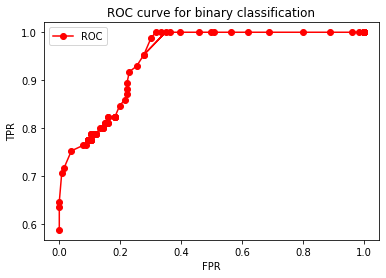

In [52]:
ROC_naive(X_test, y_test, priors_naive, naive_params0, naive_params1)

### MAP